## Rotor: Efisiensi vs Flow Coeff & Work Coeff


##### Imports


In [ ]:
# IMPORTS
import numpy as np
import CoolProp
from CoolProp.CoolProp import PropsSI as Props
from CoolProp.CoolProp import PhaseSI as Phase
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

##### INPUTS: PARAMETERS & INLET OUTLET STATES

In [119]:
#INPUT TURBINE INLET & OUTLET FLUID STATE
def whichcycle (k):
    global T_1,T_5,P_1,P_5,mflow,fluid #Total Temperature (K),Total Pressure(P),'Nama fluida'
    if k == 1:
        T_1 = 360   
        T_5 = 335.4     
        P_1 = 0.9   *1e6
        P_5 = 0.3   *1e6
        fluid = 'R245fa'
        mflow = 1.3
    if k == 2:
        T_1 = 420
        P_1 = 1.0      *1e6
        P_5 = Props('P','H',Props('H','T',T_1,'P',P_1,'N-PENTANE')-102*1e3,'S',Props('S','T',T_1,'P',P_1,'N-PENTANE'),'N-PENTANE')
        T_5 = Props('T','P',P_5,'S',Props('S','T',T_1,'P',P_1,'N-PENTANE'),'N-PENTANE')
        fluid = 'N-PENTANE' 
        mflow = 0.672
    if k == 3:
        T_1 = 325
        T_5 = 310
        P_1 = 1     *1e6
        P_5 = 0.693     *1e6
        fluid = 'PROPANE' 
        mflow = 1
    if k == 4:
        T_1 = 339.41
        T_5 = 310
        P_1 = 1.4   *1e6
        P_5 = 0.693 *1e6
        fluid = 'PROPANE' 
        mflow = 1
    if k == 5:      # => uji siklus dari fiaschi 2015
        T_1 = 420
        P_1 = 3.1   *1e6
        P_5 = 0.8109 *1e6
        T_5 = Props('T','P',P_5,'S',Props('S','T',T_1,'P',P_1,'R1234yf'),'R1234yf')

        fluid = 'R1234yf' 
        mflow = 2.327
    if k == 6:      
        T_1 = 332.65
        P_1 = 1.2   *1e6
        P_5 = 0.693 *1e6
        T_5 = 309.99

        fluid = 'PROPANE' 
        mflow = 1    
    if k ==7:
        T_1 = 344
        P_1 = 0.07041   *1e6
        P_5 = 0.02167 *1e6
        T_5 = 316.2
        fluid = 'CYCLOHEXANE' 
        mflow = 0.8        
    if k ==8:
        T_1 = 333.42
        P_1 = 0.0475   *1e6
        P_5 = 0.01995 *1e6
        T_5 = 313
        fluid = 'CYCLOHEXANE' 
        mflow = 1     

In [110]:
    global k5h4,kb4b,rath5,rats5,rpm,Zratio,NR
    Rrh5r4  = 0.12   # ratio antara rh5 dengan r4 => 0<(rh5/r4) <1
    Rb5b4   = 1.5      # ratio antara b5 dengan b4 => b5/b4; preferrably >1
    # rath5   = 0.4
    # rats5   = 0.75
    rpm     = 20000
    Zratio  = 0.8
    NR      = 12


##### Define Compute Function

INPUT 10 x flow coeff dan 10x work coeff, serta siklus nomor berapa

In [ ]:
def Compute(tenflow_coeff,tenwork_coeff,k): #INPUT 10 X flow atau work coeff

    global  T_1,T_5,P_1,P_5,p04s,p05ss,T04s,T05ss,h04,h05,h05ss,h5,h5ss,h01,DeltaH
    global  T4,T4s,p4,p4s,T5,p5
    global  NR,r4,r5,rh5,rs5,b4,b5,Zr
    global  C4,Ct4,Cm4,W4,U4,Alpha4,Beta4,C5,Ct5,Cm5,W5,U5,Alpha5,Beta5,Beta4opt
    global  C5didconverge1,C5didconverge2,k1C5,k2C5,errorC5
    global  rho4,rho4s,rho04,rho04s,a4s,a5ss,Ma4,Ma4ss
    global TotalLoss,LossInc,LossPass,LossTip,LossWind,LossTE,LossExit,rho4m,S5,O5
    global Effts,Efftt,Efftspred,Reaction
    global s04s,T04,T04s,p04,p04s,s04,etaspred,rho4sm,rho4,rho04,a5ss,rho5ss,p5ss,k1C5,k2C5

    flow_coeff=tenflow_coeff/10
    work_coeff=tenwork_coeff/10
    whichcycle (k)       # The cycle to be computed is the k
    
    Cp4 = Props('C','T',T_1,'P',P_1,fluid)
    Cv4 = Props('O','T',T_1,'P',P_1,fluid)
    gamma = Cp4/Cv4
    Rx = 8.31446261815324   #J/K.mol

    #General Properties inlet outlet turbin (Total)
    H_1     = Props('H','T',T_1,'P',P_1,fluid)     #J/kg
    s01     = Props('S','T',T_1,'P',P_1,fluid)     #J/kg.K 
    T_5     = Props('T','P',P_5,'S',s01,fluid)  # =>asumsi nozzle isenthalpy DAN Isentropic
    H_5     = Props('H','T',T_5,'P',P_5,fluid)  # meski pada kenyataannya isenthalpic nozzle tidak isentropic
    DeltaH  = H_1-H_5            #Ideal === Isentropic Total Enthalpy change 

    C0s     = np.sqrt(2*DeltaH)         #Spouting Velocity

    #Segitiga Kecepatan Inlet, m/s, radians
    U4      = np.sqrt(DeltaH/work_coeff)
    Cm4     = U4*flow_coeff
    Ct4     = DeltaH/U4                 # => DeltaH = U4*Ct4-U5*Ct5 ; Alpha5=0 => Ct5=0
    C4      = np.sqrt(Cm4**2+Ct4**2)
    Alpha4  = np.arctan(Ct4/Cm4)
    W4      = np.sqrt(Cm4**2+(U4-Ct4)**2)
    Beta4   = np.arctan((U4-Ct4)/Cm4)

    #Perhitungan Properties ideal lain (Total)
    p01     = P_1           #inlet volute [1], Total
    T01     = T_1
    h01     = H_1
    p1      = p01
    T1      = T_1
    h01     = H_1
    rho1   = Props('D','P',p1,'T',T1,fluid)
    
    p05ss   = P_5
    T05ss   = T_5
    h05ss   = H_5
    s05ss   = Props('S','H',h05ss,'P',p05ss,fluid)
    rho05ss = Props('D','P',p05ss,'T',T05ss,fluid)

    Q5      = mflow/rho05ss
    ns      = np.radians(rpm*6)*np.sqrt(Q5)/DeltaH**0.75
    Efftspred    = 0.81-1.07*(ns-0.55)**2-0.5*(ns-0.55)**3       #predicted total-to-static efficiency

    
    h02s    = H_1           #inlet nozzle [2], Total
    s02s    = s01            #ideal volute === approx. as isentropic
    p02s    = p01
    T02s    = T01
    h03s    = h02s           #outlet nozzle [3], Total
    s03s    = s02s            #ideal nozzle === approx. as isentropic (in Total)
    p03s    = p02s
    T03s    = T02s
    h04s    = h03s           #inlet rotor [4], Total
    s04s    = s03s           #outlet nozzle === inlet rotor
    p04s    = p03s
    T04s    = T03s
    h04     = h04s          # Nozzle isenthalpic but not isentropic
    p04     = p01-rho1*DeltaH*(1-Efftspred)/4
    T04     = Props('T','P',p04,'H',h04s,fluid)
    s04     = Props('S','P',p04,'T',T04,fluid)
    
    h05ss   = H_5
    p05ss   = P_5
    T05ss   = T_5
    s05ss   = Props('S','H',h05ss,'P',p05ss,fluid)

    #Perhitungan Properties ideal lain (Static)
    h4s     = h04s-1/2*C4**2
    p4s     = Props('P','H',h4s,'S',s04s,fluid)
    p4      = Props('P','H',h4s,'S',s04,fluid)
    T4s     = Props('T','H',h4s,'S',s04s,fluid)
    rho04s  = Props('D','P',p04s,'T',T04s,fluid)
    rho4s   = Props('D','P',p4s,'T',T4s,fluid)
    rho4sm  = 2*(p04s-p4s)/C4**2
    h4      = h04-1/2*C4**2
    p4      = Props('P','H',h4,'S',s04,fluid)
    T4      = Props('T','H',h4,'S',s04,fluid)
    rho04   = Props('D','P',p04,'T',T04,fluid)
    rho4    = Props('D','P',p4,'H',h04,fluid)
    rho4m   = 2*(p04-p4)/C4**2
    a01     = Props('A','P',p01,'T',T01,fluid)
    a4s     = Props('A','P',p4s,'T',T4s,fluid)
    a4      = Props('A','P',p4,'T',T4,fluid)
    Ma4s    = C4/a4s
    Ma4     = C4/a4



    #Perhitungan Geometri 
    r4  = U4/np.radians(rpm*6)
    b4  = mflow/(2*np.pi*r4*rho4s*Cm4)
    D4  = r4*2
    Zr  = Zratio*r4
    rh5 = Rrh5r4*r4
    b5  = Rb5b4*b4  
    rs5 = rh5+b5
    r5  = (rs5+rh5)/2

    Re4s    = rho4s*C4*b4/Props('V','P',p4s,'T',T4s,fluid)
    Re4     = rho4*C4*b4/Props('V','P',p4,'T',T4,fluid)

    #Segitiga Kecepatan Outlet
    U5      = r5*np.radians(rpm*6)
    C5_0    = 0
    rho5ss_0= rho05ss
    C5ii    = C5_0
    rho5ssii= rho5ss_0
    C5didconverge1 = False
    C5didconverge2 = False
    k1C5    = 0
    k2C5    = 0
    while C5didconverge1 == False:
        k1C5     = k1C5+1             # => iteration number
        C5i      = C5ii
        rho5ssi = rho5ssii
        C5ii    = mflow/(rho5ssi*2*np.pi*r5*b5)
        h5ss    = h05ss-1/2*C5ii**2
        rho5ssii  = Props('D','H',h5ss,'S',s05ss,fluid)
        errorC5= mflow/(rho5ssii*C5ii*2*np.pi*b5*r5)-1
        if np.abs(errorC5) <= 10**-10:
            C5didconverge1 = True
            C5didconverge2 = True
            C5  = C5ii
            rho5ss=rho5ssii
            break
        if (rho5ssi*C5i-rho5ssii*C5ii)*(C5i-C5ii)<0:
            C5      = C5ii
            rho5ss  = rho5ssii
            break
    while C5didconverge2 == False:
        k2C5    = k2C5 +1
        C5      = mflow/(rho5ss*2*np.pi*r5*b5)
        h5ss    = h05ss-1/2*C5**2
        rho5ss  = Props('D','H',h5ss,'S',s05ss,fluid)
        errorC5= mflow/(rho5ss*C5*2*np.pi*b5*r5)-1
        if errorC5 <= 10**-10:
            C5didconverge2 = True
            break
    h5ss    = h05ss-1/2*C5**2
    Alpha5  = 0
    Ct5     = C5*np.sin(Alpha5)
    Cm5     = C5*np.cos(Alpha5)
    Beta5   = np.arctan((U5-Ct5)/Cm5)
    W5      = Cm5/np.cos(Beta5)

    S5      = 2*np.pi*r5/NR
    O5      = S5*Cm5/W5

    p5ss    = Props('P','H',h5ss,'S',s05ss,fluid)
    a5ss    = Props('A','H',h5ss,'P',p5ss,fluid)
    Ma5ss   = C5/a5ss


    # \\\\\\\ <<---------<<----||----->>------------>> ////////
    ## Losses Coefficient ##

    #Rotor Incidence Losses
    Beta4opt = np.arctan((-1.98/NR)/NR/(1-1.98/NR)*np.tan(Alpha4))
    LossInc = 0.5*(W4**2)*(np.sin(np.abs(Beta4-Beta4opt)))**2  #m2/s2

    #Rotor Passage Losses
    LH = np.pi/4*((Zr-b4/2)+(r4-rh5-b5/2))                                                              #m
    DH = 0.5*((4*np.pi*r4*b4/(2*np.pi*r4+Zr*rh5))+((2*np.pi*(rs5**2-rh5**2)/(np.pi*(rs5-rh5))+Zr*b5)))  #m
    Y5 = np.arctan(0.5*(np.tan(Beta4)+np.tan(Beta5)))
    C = Zr/np.cos(Y5)
    if (r4-rs5)/b5>=0.2:
        KpCETI = 0.11
    else:
        KpCETI = 0.22
    LossPass = KpCETI*(LH/DH+0.68*((1-(r5/r4)**2)*np.cos(Beta5)/(b5/C))*((W4**2+W5**2)/2))
    
    #Rotor Clearance Losses
    Ca = (1-(rs5/r4))/(Cm4*b4)
    Cr = (rs5/r4)*((Zr-b4)/(Cm5*r5*b5))
    Ka = 0.4
    Kr = 0.75
    Kar = -0.3
    Ea = 0.0003
    Er = 0.0003
    if Ea*Er*Ca*Cr>=0:
        LossTip = (U4**3*NR/(8*np.pi))*(Ka*Ea*Ca+Kr*Er*Cr+Kar*np.sqrt(Ea*Er*Ca*Cr))
    else:
        LossTip = 0
    #Windage Losses
    Eb = 0.0003
    Kf = 3.7*(Eb/r4)**0.1/Re4s**0.5
    LossWind = Kf*((rho4s+rho5ss)/2)*U4**3*r4**2/(2*mflow*W5**2)

    #Trailing Edge Losses
    tb4 = 0.04*r4
    tb5 = 0.02*r4
    LossTE = rho5ss*W5**2/2*(NR*tb5/(np.pi*(rh5+rs5)*np.cos(Beta5)))**2
    
    #Exit Losses
    LossExit = 0.5*C5**2    # => mungkin untuk ubah dari total jadi static. abaikan dulu

    # => Sum Enthalpy Losses
    TotalLoss = LossInc + LossPass + LossTip + LossWind + LossTE
    # \\\\\\\ <<---------<<----||----->>------------>> ////////


    #Perhitungan Properties considering losses
    h05 = h05ss+TotalLoss#bentar masih salah lossnya       #nozzle masih diasumsikan isentropic dan isenthalpic
    h5  = h05-1/2*C5**2     
    p05 = p05ss
    T05 = Props('T','H',h05,'P',p05,fluid)
    p5  = p5ss
    T5  = Props('T','H',h5,'P',p5,fluid)

    #Effisiensi 
    Reaction    = (h4s-h5)/(h01-h05ss)
    Efftt       = (h01-h05)/(h01-h05ss)*100
    Effts       = (h01-h05)/(h01-h5ss)*100



##### Gather data & plots

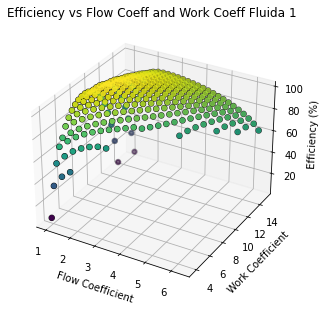

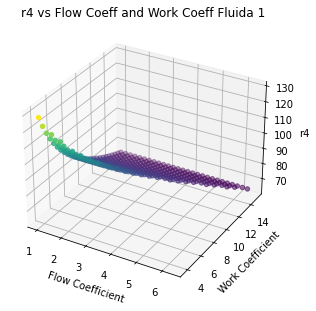

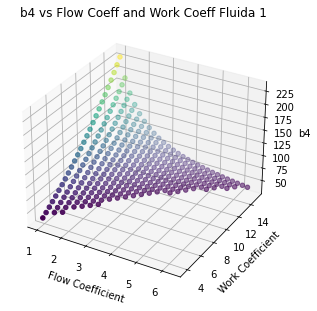

In [121]:
#Caclulate Eff & plot -RWM

Efficiencyarray_fluid1 = []
#Var1_List = []                                  #Flow Coeff Var1
#Var2_List = []                                  #Work Coeff Var2
MaxVar1 = 11                                 #Max Flow Coeffx10 in axis
MinVar1 = 1                                 #Min Flow Coeffx10 in axis
MaxVar2 = 15                                   #Max Work Coeffx10 in axis
MinVar2 = 2                                   #Min Work Coeffx10 in axis
ndata1 = 50
ndata2 = 30
x_data1 = []
y_data1 = []
z_data1 = []
x_datapos1 = []
y_datapos1 = []
z_datapos1 = []
x_dataneg1 = []
y_dataneg1 = []
z_dataneg1 = []
x_data2 = []
y_data2 = []
z_data2 = []
x_datapos2 = []
y_datapos2 = []
z_datapos2 = []
x_dataneg2 = []
y_dataneg2 = []
z_dataneg2 = []

#Var3 = fluid1 ...................................................
dataindex=0      #index data di array efficiency
for i in range(0, ndata2):                                #generate data for fluid 1 and fluid 2
  try:
    dvar2 = (MaxVar2-MinVar2)/(ndata2-1)
    Var2 = MinVar2 + i*dvar2
    for j in range(0,ndata1):
      dvar1 = (MaxVar1-MinVar1)/(ndata1-1)
      Var1 = MinVar1 + j*dvar1
      Compute(Var1,Var2,8)      # <=== Ubah siklus nomor berapanya
      #Fluida 1
      z_data1.append(r4*1000)
      x_data1.append(Var1)
      y_data1.append(Var2)
      z_data2.append(b4*1000)
      x_data2.append(Var1)
      y_data2.append(Var2)
      dataindex=dataindex+1
      if Effts >= 0:
        z_datapos1.append(Effts)
        x_datapos1.append(Var1)
        y_datapos1.append(Var2)
      if Effts < 0:
        z_dataneg1.append(Effts)
        x_dataneg1.append(Var1)
        y_dataneg1.append(Var2)
  except ValueError:
    pass
    #Fluida 2
    # z_data2.append(Efficiency2*100)
    # x_data2.append(Var1)
    # y_data2.append(Var2)
    # dataindex=dataindex+1
    # if Efficiency2 >= 0:
    #   z_datapos2.append(Efficiency2*100)
    #   x_datapos2.append(Var1)
    #   y_datapos2.append(Var2)
    # if Efficiency1 < 0:
    #   z_dataneg2.append(Efficiency2*100)
    #   x_dataneg2.append(Var1)
    #   y_dataneg2.append(Var2)


#Fluida 1
fig = plt.figure(figsize=(5, 5))
ax = plt.axes(projection ="3d")
ax.scatter(x_datapos1, y_datapos1, z_datapos1, lw=2, c='Black', cmap = "viridis")
ax.scatter(x_datapos1, y_datapos1, z_datapos1, lw=1, c=z_datapos1, cmap = "viridis")
# ax.scatter(x_dataneg1, y_dataneg1, z_dataneg1, lw=1, c=z_dataneg1, cmap = "autumn")
ax.set_title("Efficiency vs Flow Coeff and Work Coeff Fluida 1")
ax.set_xlabel("Flow Coefficient")
ax.set_ylabel("Work Coefficient")
ax.set_zlabel("Efficiency (%)")
plt.show()
fig = plt.figure(figsize=(5, 5))
ax = plt.axes(projection ="3d")
ax.scatter(x_data1, y_data1, z_data1, lw=1,c=z_data1, cmap = "viridis")
ax.set_title("r4 vs Flow Coeff and Work Coeff Fluida 1")
ax.set_xlabel("Flow Coefficient")
ax.set_ylabel("Work Coefficient")
ax.set_zlabel("r4")
plt.show()
fig = plt.figure(figsize=(5, 5))
ax = plt.axes(projection ="3d")
ax.scatter(x_data2, y_data2, z_data2, lw=1,c=z_data2, cmap = "viridis")
ax.set_title("b4 vs Flow Coeff and Work Coeff Fluida 1")
ax.set_xlabel("Flow Coefficient")
ax.set_ylabel("Work Coefficient")
ax.set_zlabel("b4")
plt.show()
# #Fluida 2
# fig = plt.figure(figsize=(9, 9))
# ax = plt.axes(projection ='3d')
# ax.scatter(x_datapos2, y_datapos2, z_datapos2, lw=2, c='Black', cmap = "viridis")
# ax.scatter(x_datapos2, y_datapos2, z_datapos2, lw=1, c=z_datapos2, cmap = "viridis")
# ax.scatter(x_dataneg2, y_dataneg2, z_dataneg2, lw=1, c=z_dataneg2, cmap = "autumn")
# ax.set_title("Efficiency vs Flow Coeff and Work Coeff Fluida 2")
# ax.set_xlabel("Flow Coefficient")
# ax.set_ylabel("Work Coefficient")
# ax.set_zlabel("Efficiency (%)")
# plt.show()

# dictionary of lists 
# dict = {'Flow Coeff f1': x_data1, 'Work Coeff f1': y_data1, 'Efficiency f1': z_data1,
#         'Flow Coeff f2': x_data2, 'Work Coeff f2': y_data2, 'Efficiency f2': z_data2} 
# dict = {'10 x Flow Coeff':x_datapos1,'10 x Work Coeff':y_datapos1,'Total-to-static Efficiency':z_datapos1}
# df = pd.DataFrame(dict)
    


In [122]:
dict = {'10 x Flow Coeff':x_datapos1,'10 x Work Coeff':y_datapos1,'Total-to-static Efficiency':z_datapos1}
df = pd.DataFrame(dict)
df.to_csv('flow and work 9 July siiklus 8.csv', index = True)

##### Run tests

In [ ]:
Compute(2.2,9,1)
print(C5,k1C5,k2C5)
print(r4,r5,b4,b5)
print(C5didconverge1,C5didconverge2)
print(errorC5)
print(Effts)

In [120]:
Compute(2.1,9.5,8)
print(C5,C4)
print(p04,p04s,p4,p4s,T4,T4s)
print("=>",r4,b4,rh5,b5,Zr)
print("=>",DeltaH,Efftspred,Efftt,Effts,Reaction)
print(np.degrees(Beta5),np.degrees(Beta4opt),np.degrees(Beta4),np.degrees(Alpha4))
print(TotalLoss)
print("=>",LossInc,LossPass,LossTip,LossWind,LossTE)
print(rho4,rho4s)
print(S5,O5)
print(h01,h05ss,h5ss,h05,a4s,C5/a5ss,Ma4)
print(C5,k1C5,k2C5)
print(C5didconverge1,C5didconverge2)
print(rho5ss*C5,mflow)

59.0620217445978 164.84894936017028
39215.52488509336 47500.0 25627.098782765035 31008.552394734117 323.15879005200594 323.36250541012856
=> 0.08089921730750767 0.05610110710028755 0.00970790607690092 0.08415166065043134 0.06471937384600614
=> 27272.783963547845 0.17513133128429134 98.08184290311173 92.1863034370929 0.5465603473433075
61.4284704760331 -4.260315303444578 13.392497753751096 77.53506715793502
523.1348411158056
=> 61.51184563111396 388.2093989006049 0 0.0016054070325330575 73.41199117705422
0.7886679024989558 0.9855579188662854
0.027113900976053304 0.012967372973397303
327752.1884161389 300479.404452591 298735.2432463114 301002.5392937068 183.04657628396524 0.32672547770148275 0.8987973912032884
59.0620217445978 10 0
True True
36.522799365343886 1


In [ ]:
Compute(1,9,1)
print(s04s)
print(s04)
print(p04)
print(p04s)
print(Efftspred)
print("rho04s=",rho04s)
print("rho4s=",rho4s)
print("rho4sm=",rho4sm)
print("rho04=",rho04)
print("rho4=",rho4)
print("rho4m=",rho4m)
print("rho5ss=",rho5ss)
print("rho05=",Props('D','T',T_5,'P',P_5,fluid))
print(Beta4,Beta4opt)
print(C5/a5ss)
print(U4*Ct4,DeltaH)

In [ ]:

print(cu(ruc(0,np.radians(70)),rcw(0,np.radians(70))))
Compute(0.2,1.1,2)
print("DeltaH=",DeltaH)
print((Ct4*U4-Ct5*U5))
print(np.abs(DeltaH-((Ct4*U4-Ct5*U5)))/DeltaH*100,"%")
print(r4)
print(r5)
print(U4)
print(U5)
print(cu4)
print(fluid)
print("cu5=",cu5)
print("cu5num=",cu5num)
print("converge?=",beta5didconverge)
print("Error Beta5=",errorbeta5)
print("Beta5=",np.degrees(Beta5))

print(TotalLoss)
print(LossInc,LossPass,LossTip,LossWind,LossTE)

In [ ]:
def testing1
    Compute(0.1,0.9,1)
    # print(h04s)
    # print(h4s)
    # print(h05ss)
    # print(h5ss)
    # print("w(by enthalpy)=",DeltaH)
    # print("w(by enthalpy)=",h04s-h05ss)
    # print("w(by vel)=",-1/2*((U5**2-U4**2)+(C5**2-C4**2)-(W5**2-W4**2)))
    # print("W(by velCtU)=",Ct4*U4-Ct5*U5)
    # print("W(by velCtU)=",Ct4*U4-C5*np.sin(Alpha5)*U5)
    print(C4/a01)
    print(C4/a4)
    print("Alpha4=",np.degrees(Alpha4))
    print("Beta4=",np.degrees(Beta4))
    print("Cm4=",Cm4)
    print("C4=",Ct4)
    print("Ct4=",C4)
    print("U4=",U4)
    print("rho4s=",rho4s)
    print("rho4s2=",rho4s2)
    print("Alpha5=",np.degrees(Alpha5))
    #print("beta5converge?=",beta5didconverge)
    print("C5 converged? =",C5didconverge)
    print("iterated for",kC5,"times")
    print("error C5=",errorC5)
    print("Beta5=",np.degrees(Beta5))
    print("Cm5=",Cm5)
    print("C5=",C5)
    print("Ct5=",Ct5)
    print("U5=",U5)
    print("r4=",r4)
    print("r5=",r5)
    print("b5=",b5,"b4=",b4)
    print("Zr=",Zr)
    print(TotalLoss)
    print(LossInc,LossPass,LossTip,LossWind,LossTE)

In [ ]:
print(DeltaH,h04s,h05ss,C5i,kC5)

##### Archives, Scrapped out parts

###### Regress & Plots

In [ ]:
from scipy.optimize import curve_fit
import random as random
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from scipy import interpolate
from mpl_toolkits.mplot3d import Axes3D
import random
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn import linear_model
from matplotlib import cm

In [ ]:
def RegressG(MinVar1,MaxVar1,MinVar2,MaxVar2):
    global Efficiency_list1
    Efficiency_List1 = []
    Efficiency_List2 = []
    Efficiency_List3 = []
    Efficiency_List4 = []
    Efficiency_List5 = []
    Efficiency_List6 = []
    NSAMPLE=700
    Var1_List = []
    Var2_List = []
    R_List=[]
    for i in range(0,NSAMPLE):

        var1  = random.uniform(MinVar1,MaxVar1)
        var2  = random.uniform(MinVar2,MaxVar2)
        # var3 = 'R245fa'
        # var4 = 'R134a'
        # var5 = 'R1234yf'
        try:
            Compute(var1,var2,3)
            if Effts>0:
                Efficiency_List1.append(Effts*100)
                Var1_List.append(var1)
                Var2_List.append(var2)
                R_List.append(Reaction)
            # Efficiency1 = Compute(var1,var2,var3)[0]
            # Efficiency2 = Compute(var1,var2,var4)[0]
            # Efficiency3 = Compute(var1,var2,var5)[0]
            # Efficiency_List1.append(Effts*100)
            # Efficiency_List2.append(Efficiency2*100)
            # reaction= Compute(var1,var2,var3)[1]
            
        except:
            pass

    #Regresi 2 Variabel
    datapoints = np.array(np.vstack((Var1_List,Var2_List,Efficiency_List1)).T)

    X = datapoints[:,0:2]
    Y = datapoints[:,-1]
    #  degree polynomial features
    deg_of_poly = 5
    poly = PolynomialFeatures(degree=deg_of_poly)
    X_ = poly.fit_transform(X)
    # Fit linear model
    clf = linear_model.LinearRegression()
    clf.fit(X_, Y)

    # The test set, or plotting set
    N = NSAMPLE
    LengthVar1 = MaxVar1
    LengthVar2 = MaxVar2
    predict_x0, predict_x1 = np.meshgrid(np.linspace(MinVar1, MaxVar1, N), 
                                        np.linspace(MinVar2, MaxVar2, N))
    predict_x = np.concatenate((predict_x0.reshape(-1, 1), 
                                predict_x1.reshape(-1, 1)), 
                            axis=1)
    predict_x_ = poly.fit_transform(predict_x)
    predict_y = clf.predict(predict_x_)

    # Plot
    fig = plt.figure(figsize=(40, 10))
    ax1 = fig.add_subplot(121, projection='3d')
    surf = ax1.plot_surface(predict_x0, predict_x1, predict_y.reshape(predict_x0.shape),rstride=1, cstride=1, cmap=cm.jet, alpha=0.5)
    ax1.scatter(datapoints[:, 0], datapoints[:, 1], datapoints[:, 2], c='b', marker='o')

    ax1.set_xlim((MinVar1, MaxVar1))
    ax1.set_ylim((MinVar2, MaxVar2))
    fig.colorbar(surf, ax=ax1)
    ax2 = fig.add_subplot(122)
    cs = ax2.contourf(predict_x0, predict_x1, predict_y.reshape(predict_x0.shape))
    ax2.contour(cs, colors='k')
    fig.colorbar(cs, ax=ax2)
    plt.show()
    KOEFISIEN=clf.coef_
    VARIABEL=poly.get_feature_names_out()
    print(KOEFISIEN)
    print(VARIABEL)

In [ ]:
x_datapos1 = []
y_datapos1 = []
z_datapos1 = []
x_dataneg1 = []
y_dataneg1 = []
z_dataneg1 = []
DeltaHtest = 20000
flow_coefftest=0
work_coefftest=0
whichcycle(1)
h04stest=Props('H','P',P_1,'T',T_1,fluid)
s04test=Props('S','P',P_1,'T',T_1,fluid)
for i in range(100):
    flow_coefftest=flow_coefftest+0.02
    for j in range(100):
        work_coefftest=work_coefftest+0.02
        U4test      = np.sqrt(DeltaHtest/work_coefftest)
        Cm4test     = U4*flow_coefftest
        Ct4test     = DeltaH/U4test                 
        C4test      = np.sqrt(Cm4test**2+Ct4test**2)
        h4stest     = h04stest-1/2*C4test**2
        if h04stest-1/2*C4test**2>=200000:
            p4stest     = Props('P','H',h4stest,'S',s04test,fluid)
            T4stest     = Props('T','H',h4stest,'S',s04test,fluid)
            a4stest     = Props('A','P',p4stest,'T',T4stest,fluid)
            Ma4stest    = C4/a4stest
            if Ma4stest <3:
                Ma4stest    = C4/a4stest
            if Ma4stest >=3:
                Ma4stest    = 3
        if h04stest-1/2*C4test**2<0:
            Ma4stest    = 3
        if Ma4stest >= 0.99:
            z_datapos1.append(Ma4stest)
            x_datapos1.append(flow_coefftest)
            y_datapos1.append(work_coefftest)
        if Ma4stest < 0.99:
            z_dataneg1.append(Ma4stest)
            x_dataneg1.append(flow_coefftest)
            y_dataneg1.append(work_coefftest)
fig = plt.figure(figsize=(9, 9))
ax = plt.axes(projection ='3d')
ax.scatter(x_datapos1, y_datapos1, z_datapos1, lw=2, c='Black', cmap = "viridis")
ax.scatter(x_datapos1, y_datapos1, z_datapos1, lw=1, c=z_datapos1, cmap = "viridis")
ax.scatter(x_dataneg1, y_dataneg1, z_dataneg1, lw=1, c=z_dataneg1, cmap = "autumn")
ax.set_title("Machs vs Flow Coeff and Work Coeff Fluida 1")
ax.set_xlabel("Flow Coefficient")
ax.set_ylabel("Work Coefficient")
ax.set_zlabel("Mach")
plt.show()
        







In [ ]:
def rcw (Alpha,Beta):   #input in radians
    return (np.cos(Alpha)/np.cos(Beta))
def ruc (Alpha,Beta):
    return (1/(np.sin(Alpha)+np.tan(Beta)*np.cos(Alpha)))
def cu (ruc,rcw):
    return (1-(ruc*rcw)**2+ruc**2)

In [ ]:
    #rho04s    = Props('D','T',T_1,'P',P_1,fluid)  #  rho4~= rho1?
    #rho05s    = Props('D','T',T_5,'P',P_5,fluid)  #kg/m3
    #rho dihitung pada static

    # Beta4   = np.radians(30)                         # =>INPUT Control Variable(rads)
    # U4      = np.sqrt(DeltaH/work_coeff)
    # Cm4     = U4*flow_coeff
    # W4      = Cm4/np.cos(Beta4)
    # Ct4     = U4-W4*np.sin(Beta4) 
    # Alpha4  = np.arctan(Ct4/Cm4)  #in radians           
    # C4      = Cm4/np.cos(Alpha4)
    # 
        #Segitiga Kecepatan Outlet
    # Alpha5  = np.radians(1)    # =>INPUT initial Control Variable(rads)
    #U5      = r5*np.radians(rpm*6)
    #cu4     = cu(ruc(Alpha4,Beta4),rcw(Alpha4,Beta4))
    #cu5     = (U4**2*cu4-2*DeltaH)/U5**2
    #     #Mencari nilai Beta5 dengan galat cu < 0.5%
    # beta5didconverge = False    #initial state
    # Beta5 = np.degrees(0.1)
    # cu5num = cu(ruc(Alpha5,Beta5),rcw(Alpha5,Beta5))
    # errorbeta5  = np.abs((cu5-cu5num)/cu5)
    # while errorbeta5>0.005:
    #     Beta5 = Beta5+np.radians(0.01)
    #     cu5num = cu(ruc(Alpha5,Beta5),rcw(Alpha5,Beta5))
    #     errorbeta5  = np.abs((cu5-cu5num)/cu5)
    #     if errorbeta5<=0.01:
    #         beta5didconverge = True
    #     if Beta5 >= np.radians(180):
    #         break
    #==> dicoba dulu pakai uct
    #Ct5     = (U4*Ct4-DeltaH)/U5
    #Cm5 = U4/(np.tan(Alpha5)+np.tan(Beta5))
    #W5  = Cm5/np.cos(Beta5)
    #C5  = Cm5/np.cos(Alpha5)
    #Ct5 = Cm5*np.tan(Alpha5)
    # Re4     = rho4s*C4*b4/Props('V','P',p04s,'T',T04s,fluid)
    # #Properties ideal static di 5
    # h5ss    = h05ss-1/2*C5**2
    # p5ss    = Props('P','H',h5ss,'S',s05ss,fluid)
    # rho5ss  = 2*(p05ss-p5ss)/C5**2
    #Segitiga Kecepatan outlet versi 2
    #Alpha5  = np.radians(20)     #  ==> INPUT Control variable
    #--------------------------====================================> V dihold dulu karena hasilnya aneh
    # C5didconverge = False 
    # C5_0    = (U4*Ct4-DeltaH)/(np.sin(Alpha5)*U5) #i=0
    # C5ii    = C5_0  #trick untuk menghemat baris
    # #errorC5 = np.abs((C5i-C5ii)/C5i)
    # kC5     = 0
    # while C5didconverge == False:
    #     kC5     = kC5 +1
    #     C5i     = C5ii
    #     h5ss    = h05ss-1/2*C5i**2
    #     #p5ss    = Props('P','H',h5ss,'S',s05ss,fluid)
    #     rho5ss  = Props('D','H',h5ss,'S',s05ss,fluid)
    #     #rho5ss  = 2*(p05ss-p5ss)/C5i**2                => scrap out
    #     C5ii    = mflow/(2*np.pi*b5*r5*rho5ss)
    #     errorC5 = np.abs((C5i-C5ii)/C5i)
    #     if errorC5 <= 0.000005:
    #         C5didconverge = True
    #         C5  = C5ii
    # U5      = (U4*Ct4-DeltaH)/(np.sin(Alpha5)*C5)
    # Cm5     = C5*np.cos(Alpha5)
    # Ct5     = C5*np.sin(Alpha5)
    # Beta5   = np.arctan((U5-Ct5)/Cm5)
    # W5      = Cm5/np.cos(Beta5)
    # r5      = U5/np.radians(rpm*6)
    # h5ss    = h05ss-1/2*C5**2
    # p5ss    = Props('P','H',h5ss,'S',s05ss,fluid)
    # T5ss    = Props('T','H',h5ss,'S',s05ss,fluid)
    # #rho5ss  = 2*(p05ss-p5ss)/C5**2
    #-------------------------------------
    
    #C5_0    = mflow/(rho05ss*2*np.pi*r5*b5)     # => C5 initial guess from mass balance
    #Ct5     = (U4*Ct4-DeltaH)/U5
    C5_0     = 0